In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')


In [4]:
df_1 = pd.read_csv('adj_close_prices.csv', parse_dates=['Date'])
df=df_1.copy()
# df
# Filter for dates from 2019 onwards
df = df[df['Date'] >= '2019-01-01']

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Sort index (optional but good practice)
df.sort_index(inplace=True)
etf_data=df.copy()

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 10 days
  - Number of stocks: 5
  - Portfolio type: long

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.707119
Annual Return  0.093681
Volatility     0.431846
Sharpe Ratio   0.216932
Max Drawdown  -0.593020


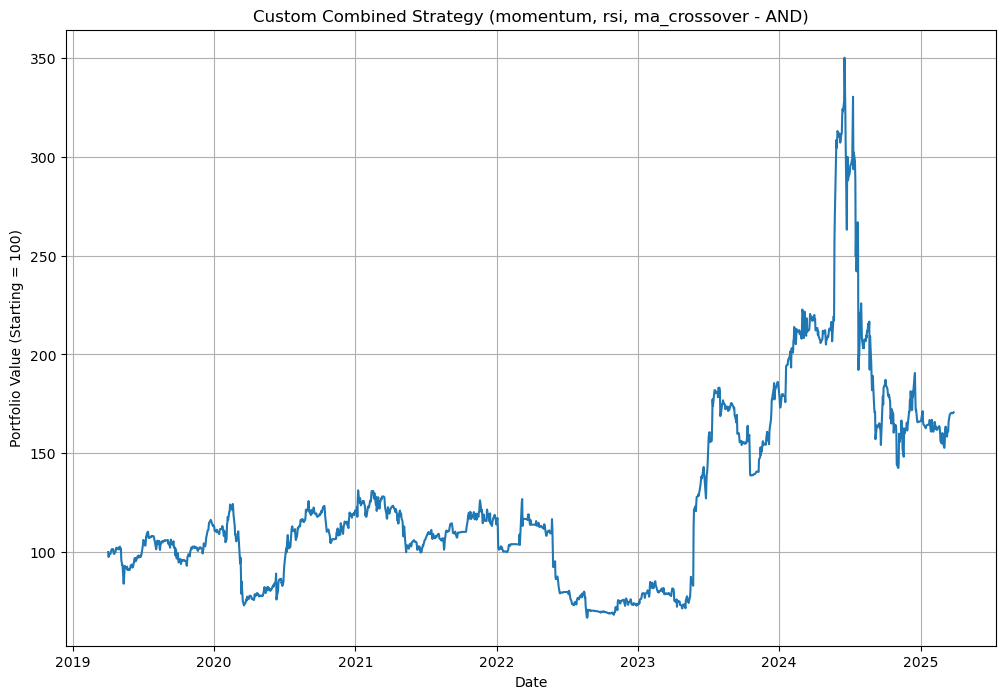

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


etf_data = df

# -------------------- STRATEGY INDICATOR FUNCTIONS --------------------

def calculate_momentum(data, lookback_period):
    """Calculate momentum as percentage price change over the lookback period"""
    return data.pct_change(lookback_period)

def calculate_rsi(data, window=14):
    """Calculate RSI for each ETF"""
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_moving_average(data, window=50):
    """Calculate moving average for each ETF"""
    return data.rolling(window=window).mean()


def create_combined_strategy(data, 
                            strategy_types=['momentum'],  
                            lookback_period=252,         
                            rsi_window=14,               
                            ma_window=50,                
                            rebalance_period=21,         
                            num_stocks=10,               
                            portfolio_type='long_short', 
                            combine_method='and'):       
    """
    Create a trading strategy with customizable parameters that can combine multiple strategy types
    
    Parameters:
    -----------
    data : pandas.DataFrame
        ETF price data with dates as index and tickers as columns
    strategy_types : list
        List of strategies to use ['momentum', 'rsi', 'ma_crossover']
    lookback_period : int
        Lookback period for momentum calculation in trading days
    rsi_window : int
        Window for RSI calculation in trading days
    ma_window : int
        Window for Moving Average calculation in trading days
    rebalance_period : int
        Number of days between portfolio rebalancing
    num_stocks : int
        Number of stocks to select for each portfolio
    portfolio_type : str
        Type of portfolio to create ('long', 'short', or 'long_short')
    combine_method : str
        Method to combine strategies ('and' or 'or')
    
    Returns:
    --------
    dict
        Dictionary containing portfolio values and holdings
    """
    # Validate inputs
    for strategy in strategy_types:
        if strategy not in ['momentum', 'rsi', 'ma_crossover']:
            raise ValueError(f"Invalid strategy type: {strategy}. Must be one of 'momentum', 'rsi', or 'ma_crossover'")
    
    if portfolio_type not in ['long', 'short', 'long_short']:
        raise ValueError("portfolio_type must be one of 'long', 'short', or 'long_short'")
    
    if combine_method not in ['and', 'or']:
        raise ValueError("combine_method must be either 'and' or 'or'")
    
    # Determine the minimum start index based on the strategies used
    min_start_indices = []
    if 'momentum' in strategy_types:
        min_start_indices.append(lookback_period)
    if 'rsi' in strategy_types:
        min_start_indices.append(rsi_window)
    if 'ma_crossover' in strategy_types:
        min_start_indices.append(ma_window)
    
    min_start_idx = max(min_start_indices) if min_start_indices else 0
    
    # Calculate indicators for each strategy
    indicators = {}
    rankings = {}
    
    if 'momentum' in strategy_types:
        indicators['momentum'] = calculate_momentum(data, lookback_period)
    
    if 'rsi' in strategy_types:
        indicators['rsi'] = calculate_rsi(data, window=rsi_window)
    
    if 'ma_crossover' in strategy_types:
        ma = calculate_moving_average(data, window=ma_window)
        indicators['ma_crossover'] = data / ma
    
    # Initialize portfolio performance trackers
    portfolio_top = pd.Series(index=data.index, dtype=float)
    portfolio_bottom = pd.Series(index=data.index, dtype=float)
    portfolio_combined = pd.Series(index=data.index, dtype=float)  # For long-short
    
    # Track holdings for each portfolio
    portfolio_top_holdings = pd.DataFrame(index=data.index, columns=data.columns, dtype=bool)
    portfolio_bottom_holdings = pd.DataFrame(index=data.index, columns=data.columns, dtype=bool)
    
    # Initialize with NaN for the initial period
    portfolio_top.iloc[:min_start_idx] = np.nan
    portfolio_bottom.iloc[:min_start_idx] = np.nan
    portfolio_combined.iloc[:min_start_idx] = np.nan
    
    # Determine rebalancing dates
    rebalance_dates = []
    current_date = data.index[min_start_idx]  # Start after the minimum required data
    while current_date <= data.index[-1]:
        rebalance_dates.append(current_date)
        # Find the next trading date that is at least rebalance_period ahead
        next_date = current_date + pd.Timedelta(days=rebalance_period)
        while next_date not in data.index and next_date <= data.index[-1]:
            next_date += pd.Timedelta(days=1)
        
        if next_date > data.index[-1]:
            break
            
        current_date = next_date
    
    # Initial portfolio value
    portfolio_value_top = 100.0
    portfolio_value_bottom = 100.0
    portfolio_value_combined = 100.0  # For long-short
    
    # For each rebalancing date
    for i, rebalance_date in enumerate(rebalance_dates):
        # Get the index position of the rebalance date
        idx = data.index.get_loc(rebalance_date)
        
        # Calculate rankings for each strategy
        for strategy in strategy_types:
            indicator_values = indicators[strategy].iloc[idx]
            
            if strategy == 'momentum':
                # For momentum, high values = good performance
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
            elif strategy == 'rsi':
                # For RSI, low values = oversold (buy), high values = overbought (sell)
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=True)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=False)
            elif strategy == 'ma_crossover':
                # For MA crossover, values > 1 mean price is above MA (buy), values < 1 mean price is below MA (sell)
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
        
        # Combine rankings based on the combine_method
        if len(strategy_types) > 1:
            if combine_method == 'and':
                # For 'and', we sum the ranks (lower sum = better combined rank)
                combined_top_rank = sum([rankings[f'{strategy}_top'] for strategy in strategy_types])
                combined_bottom_rank = sum([rankings[f'{strategy}_bottom'] for strategy in strategy_types])
            else:  # 'or'
                # For 'or', we take the minimum rank (best in any strategy)
                combined_top_rank = pd.DataFrame([rankings[f'{strategy}_top'] for strategy in strategy_types]).min()
                combined_bottom_rank = pd.DataFrame([rankings[f'{strategy}_bottom'] for strategy in strategy_types]).min()
        else:
            # If only one strategy, use its rankings directly
            combined_top_rank = rankings[f'{strategy_types[0]}_top']
            combined_bottom_rank = rankings[f'{strategy_types[0]}_bottom']
        
        # Select top and bottom performers based on the combined rankings
        top_assets = combined_top_rank.nsmallest(num_stocks).index
        bottom_assets = combined_bottom_rank.nsmallest(num_stocks).index
        
        # Update holdings for this rebalance period
        for ticker in data.columns:
            portfolio_top_holdings.loc[rebalance_date, ticker] = ticker in top_assets
            portfolio_bottom_holdings.loc[rebalance_date, ticker] = ticker in bottom_assets
        
        # Find the next rebalance date or the end of data
        next_rebalance_date = rebalance_dates[i+1] if i+1 < len(rebalance_dates) else data.index[-1]
        period_dates = data.index[(data.index >= rebalance_date) & (data.index <= next_rebalance_date)]
        
        # Calculate daily returns for each ETF during this period
        daily_returns = data.loc[period_dates].pct_change()
        daily_returns.iloc[0] = 0  # Set first day's return to 0 to avoid NaN
        
        # Calculate equally-weighted portfolio returns for each day
        for date in period_dates:
            if date == rebalance_date:
                # Record the portfolio values at rebalance date
                portfolio_top.loc[date] = portfolio_value_top
                portfolio_bottom.loc[date] = portfolio_value_bottom
                portfolio_combined.loc[date] = portfolio_value_combined
                continue
                
            # Get current holdings
            current_top = portfolio_top_holdings.loc[rebalance_date]
            current_bottom = portfolio_bottom_holdings.loc[rebalance_date]
            
            # Calculate portfolio returns (equally weighted)
            port_return_top = daily_returns.loc[date, current_top].mean() if current_top.any() else 0
            
            # For short positions, we want to make money when prices go down, so flip the sign
            port_return_bottom = -daily_returns.loc[date, current_bottom].mean() if current_bottom.any() else 0
            
            # Update portfolio values
            portfolio_value_top *= (1 + port_return_top)
            portfolio_value_bottom *= (1 + port_return_bottom)
            
            # For long-short, we combine both strategies (half weight to each)
            if portfolio_type == 'long_short':
                port_return_combined = 0.5 * port_return_top + 0.5 * port_return_bottom
                portfolio_value_combined *= (1 + port_return_combined)
            
            # Record portfolio values
            portfolio_top.loc[date] = portfolio_value_top
            portfolio_bottom.loc[date] = portfolio_value_bottom
            portfolio_combined.loc[date] = portfolio_value_combined
            
            # Copy holdings forward
            portfolio_top_holdings.loc[date] = portfolio_top_holdings.loc[rebalance_date]
            portfolio_bottom_holdings.loc[date] = portfolio_bottom_holdings.loc[rebalance_date]
    
    # Construct the requested portfolio type
    if portfolio_type == 'long':
        final_portfolio = portfolio_top
        final_holdings = portfolio_top_holdings
    elif portfolio_type == 'short':
        final_portfolio = portfolio_bottom
        final_holdings = portfolio_bottom_holdings
    else:  # long_short
        final_portfolio = portfolio_combined
        # For long-short, we create a combined holdings dataframe
        final_holdings = pd.DataFrame(index=data.index, columns=data.columns)
        for date in data.index:
            if date in portfolio_top_holdings.index and date in portfolio_bottom_holdings.index:
                for ticker in data.columns:
                    # 1 for long, -1 for short, 0 for no position
                    if portfolio_top_holdings.loc[date, ticker]:
                        final_holdings.loc[date, ticker] = 1
                    elif portfolio_bottom_holdings.loc[date, ticker]:
                        final_holdings.loc[date, ticker] = -1
                    else:
                        final_holdings.loc[date, ticker] = 0
    
    return {
        'portfolio_values': final_portfolio,
        'holdings': final_holdings,
        'portfolio_top': portfolio_top,
        'portfolio_bottom': portfolio_bottom,
        'portfolio_combined': portfolio_combined,
        'top_holdings': portfolio_top_holdings,
        'bottom_holdings': portfolio_bottom_holdings,
        'strategies_used': strategy_types,
        'combine_method': combine_method
    }



def calculate_performance_metrics(portfolio_values):
    """Calculate performance metrics for a portfolio with safeguards against invalid values"""
    # Calculate daily returns
    daily_returns = portfolio_values.pct_change().dropna()
    
    # Calculate metrics with safeguards
    try:
        total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    except (ZeroDivisionError, IndexError):
        total_return = float('nan')
    
    # Calculate annual return
    try:
        annual_return = (1 + total_return) ** (252 / len(portfolio_values)) - 1
    except (ValueError, ZeroDivisionError):
        annual_return = float('nan')
    
    # Calculate volatility
    volatility = daily_returns.std() * np.sqrt(252)
    
    # Calculate Sharpe ratio
    try:
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    except (ZeroDivisionError, ValueError):
        sharpe_ratio = float('nan')
    
    # Calculate max drawdown
    try:
        max_drawdown = (portfolio_values / portfolio_values.cummax() - 1).min()
    except ValueError:
        max_drawdown = float('nan')
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }


def plot_strategy_performance(strategies_dict, title="Strategy Performance"):
    """Plot the performance of multiple strategies"""
    plt.figure(figsize=(12, 8))
    
    for name, portfolio in strategies_dict.items():
        # Normalize to 100
        normalized = 100 * portfolio / portfolio.iloc[0]
        plt.plot(normalized.index, normalized, label=name)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.legend()
    plt.grid(True)
    return plt



# -------------------- CUSTOM COMBINED STRATEGY FUNCTION --------------------

def create_custom_combined_strategy(data, 
                                   strategy_types=['momentum', 'rsi'],  # List of strategies to use
                                   lookback_period=252,                # For momentum
                                   rsi_window=14,                      # For RSI
                                   ma_window=50,                       # For moving average
                                   rebalance_period=21,                # Days between rebalancing
                                   num_stocks=10,                      # Number of stocks to select
                                   portfolio_type='long_short',        # 'long', 'short', 'long_short'
                                   combine_method='and'):              # 'and' or 'or'
    """
    Create a custom combined strategy with user-specified parameters
    
    Returns the strategy results and performance metrics
    """
    print(f"Creating custom combined strategy with parameters:")
    print(f"  - Strategies used: {strategy_types}")
    print(f"  - Combination method: {combine_method}")
    print(f"  - Lookback period: {lookback_period} days")
    print(f"  - RSI window: {rsi_window} days")
    print(f"  - MA window: {ma_window} days")
    print(f"  - Rebalance period: {rebalance_period} days")
    print(f"  - Number of stocks: {num_stocks}")
    print(f"  - Portfolio type: {portfolio_type}")
    
    # Create the strategy
    result = create_combined_strategy(
        data,
        strategy_types=strategy_types,
        lookback_period=lookback_period,
        rsi_window=rsi_window,
        ma_window=ma_window,
        rebalance_period=rebalance_period,
        num_stocks=num_stocks,
        portfolio_type=portfolio_type,
        combine_method=combine_method
    )
    
    # Calculate performance metrics
    portfolio_values = result['portfolio_values'].dropna()
    metrics = calculate_performance_metrics(portfolio_values)
    
    # Plot the performance
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_values.index, portfolio_values / portfolio_values.iloc[0] * 100)
    plt.title(f"Custom Combined Strategy ({', '.join(strategy_types)} - {combine_method.upper()})")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.grid(True)
    
    return {
        'result': result,
        'metrics': metrics,
        'plot': plt
    }
# This fixes the issues in the create_combined_strategy function
# The key changes are in how portfolio values are calculated, especially for short positions


# Example of using the custom combined strategy function
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],  # Use all three strategies
    lookback_period=63,                                  # ~3 months for momentum
    rsi_window=10,                                       # 10-day RSI
    ma_window=20,                                        # 20-day MA
    rebalance_period=10,                                 # 10-day rebalancing
    num_stocks=5,                                        # Select top/bottom 5 stocks
    portfolio_type='long',                               # Long-only portfolio
    combine_method='and'                                 # Require agreement across strategies
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 10 days
  - Number of stocks: 5
  - Portfolio type: long_short

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.158571
Annual Return  0.024952
Volatility     0.300053
Sharpe Ratio   0.083157
Max Drawdown  -0.496974


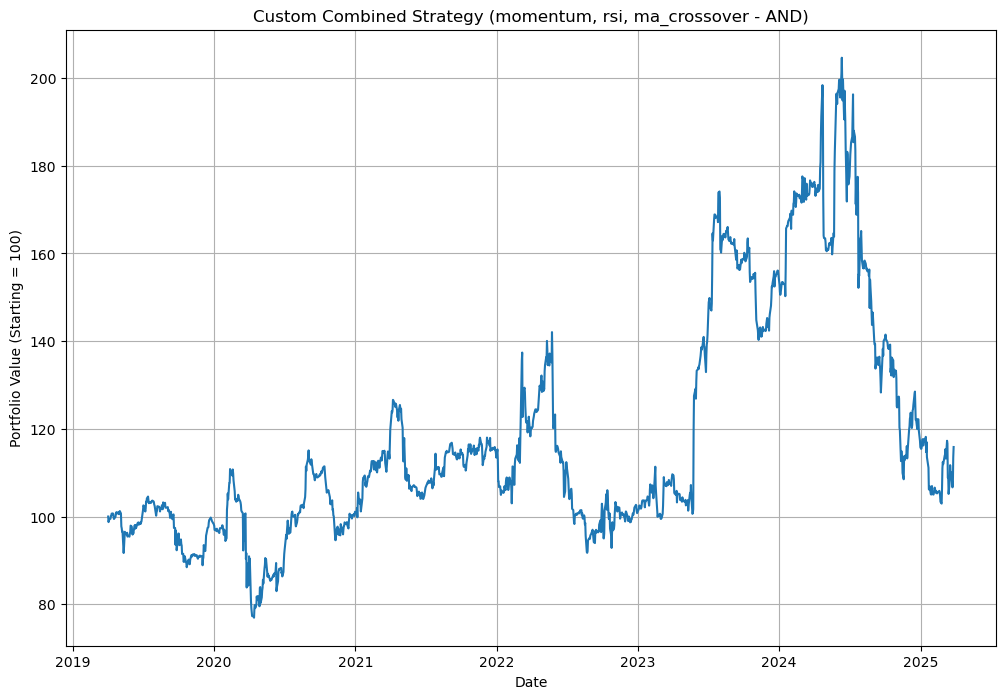

In [ ]:
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],  # Use all three strategies
    lookback_period=63,                                  # ~3 months for momentum
    rsi_window=10,                                       # 10-day RSI
    ma_window=20,                                        # 20-day MA
    rebalance_period=30,                                 # 10-day rebalancing
    num_stocks=5,                                        # Select top/bottom 5 stocks
    portfolio_type='long_short',                               # Long-only portfolio
    combine_method='and'                                 # Require agreement across strategies
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures
import itertools
import time
from tqdm.notebook import tqdm  # For progress tracking (use tqdm instead if not in notebook)

def optimize_strategy(data, 
                     strategy_types_options=[['momentum'], ['rsi'], ['ma_crossover'], 
                                           ['momentum', 'rsi'], ['momentum', 'ma_crossover'], 
                                           ['rsi', 'ma_crossover'], ['momentum', 'rsi', 'ma_crossover']],
                     lookback_periods=[21, 63, 126, 252],  # ~1 month, 3 months, 6 months, 12 months
                     rsi_windows=[5, 10, 14, 21],
                     ma_windows=[10, 20, 50, 100],
                     rebalance_periods=[5, 10, 21, 42],  # ~1 week, 2 weeks, 1 month, 2 months
                     num_stocks_options=[3, 5, 10],
                     portfolio_types=['long', 'short', 'long_short'],
                     combine_methods=['and', 'or'],
                     max_workers=8,  # Number of parallel threads
                     progress_bar=True):
    """
    Optimize the ETF trading strategy by testing combinations of parameters.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        ETF price data with dates as index and tickers as columns
    
    Returns:
    --------
    pandas.DataFrame
        Results of the optimization with strategy parameters and performance metrics
    """
    start_time = time.time()
    print(f"Starting strategy optimization...")
    
    # Generate all parameter combinations
    all_params = []
    total_combos = 0
    
    for strategy_types in strategy_types_options:
        for portfolio_type in portfolio_types:
            for num_stocks in num_stocks_options:
                for rebalance_period in rebalance_periods:
                    
                    # For single strategy types, no need for combine_method
                    if len(strategy_types) == 1:
                        strategy = strategy_types[0]
                        
                        if strategy == 'momentum':
                            for lookback_period in lookback_periods:
                                all_params.append({
                                    'strategy_types': [strategy],
                                    'lookback_period': lookback_period,
                                    'rsi_window': 14,  # Default
                                    'ma_window': 50,   # Default
                                    'rebalance_period': rebalance_period,
                                    'num_stocks': num_stocks,
                                    'portfolio_type': portfolio_type,
                                    'combine_method': 'and'  # Doesn't matter for single strategy
                                })
                                total_combos += 1
                        
                        elif strategy == 'rsi':
                            for rsi_window in rsi_windows:
                                all_params.append({
                                    'strategy_types': [strategy],
                                    'lookback_period': 252,  # Default
                                    'rsi_window': rsi_window,
                                    'ma_window': 50,   # Default
                                    'rebalance_period': rebalance_period,
                                    'num_stocks': num_stocks,
                                    'portfolio_type': portfolio_type,
                                    'combine_method': 'and'  # Doesn't matter for single strategy
                                })
                                total_combos += 1
                        
                        elif strategy == 'ma_crossover':
                            for ma_window in ma_windows:
                                all_params.append({
                                    'strategy_types': [strategy],
                                    'lookback_period': 252,  # Default
                                    'rsi_window': 14,  # Default
                                    'ma_window': ma_window,
                                    'rebalance_period': rebalance_period,
                                    'num_stocks': num_stocks,
                                    'portfolio_type': portfolio_type,
                                    'combine_method': 'and'  # Doesn't matter for single strategy
                                })
                                total_combos += 1
                    
                    # For combined strategies, we need to test different combine_methods
                    else:
                        for combine_method in combine_methods:
                            # Select appropriate parameter combinations based on strategies
                            uses_momentum = 'momentum' in strategy_types
                            uses_rsi = 'rsi' in strategy_types
                            uses_ma = 'ma_crossover' in strategy_types
                            
                            lookback_options = lookback_periods if uses_momentum else [252]
                            rsi_options = rsi_windows if uses_rsi else [14]
                            ma_options = ma_windows if uses_ma else [50]
                            
                            # If we have multiple strategies, limit the combinations to control the total
                            if len(strategy_types) > 1:
                                # Take a sample of combinations for multiple strategies
                                for lookback_period in lookback_options:
                                    for rsi_window in rsi_options:
                                        for ma_window in ma_options:
                                            all_params.append({
                                                'strategy_types': strategy_types,
                                                'lookback_period': lookback_period,
                                                'rsi_window': rsi_window,
                                                'ma_window': ma_window,
                                                'rebalance_period': rebalance_period,
                                                'num_stocks': num_stocks,
                                                'portfolio_type': portfolio_type,
                                                'combine_method': combine_method
                                            })
                                            total_combos += 1
    
    print(f"Generated {total_combos} parameter combinations to test")
    
    # Function to evaluate a single parameter set
    def evaluate_parameter_set(params):
        try:
            result = create_combined_strategy(
                data,
                strategy_types=params['strategy_types'],
                lookback_period=params['lookback_period'],
                rsi_window=params['rsi_window'],
                ma_window=params['ma_window'],
                rebalance_period=params['rebalance_period'],
                num_stocks=params['num_stocks'],
                portfolio_type=params['portfolio_type'],
                combine_method=params['combine_method']
            )
            
            portfolio_values = result['portfolio_values'].dropna()
            
            # Only calculate metrics if we have valid portfolio values
            if len(portfolio_values) > 0:
                metrics = calculate_performance_metrics(portfolio_values)
                
                # Add strategy parameters to the metrics
                metrics_with_params = params.copy()
                metrics_with_params.update(metrics)
                
                # Add strategy name
                strategy_name = ", ".join(params['strategy_types'])
                if len(params['strategy_types']) > 1:
                    strategy_name += f" ({params['combine_method'].upper()})"
                    
                metrics_with_params['strategy_name'] = strategy_name
                
                return metrics_with_params
            else:
                return None
        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            return None
    
    # Run the evaluations in parallel
    results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        if progress_bar:
            futures = list(tqdm(executor.map(evaluate_parameter_set, all_params), total=len(all_params)))
        else:
            futures = list(executor.map(evaluate_parameter_set, all_params))
        
        # Filter out None results
        results = [result for result in futures if result is not None]
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Optimization completed in {elapsed_time:.2f} seconds, evaluated {len(results_df)} valid parameter combinations")
    
    # Sort by Sharpe ratio (descending)
    if 'Sharpe Ratio' in results_df.columns:
        results_df = results_df.sort_values('Sharpe Ratio', ascending=False)
    
    return results_df

def plot_top_strategies(results_df, data, top_n=5, metric='Sharpe Ratio'):
    """
    Plot the performance of the top N strategies based on the specified metric
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    data : pandas.DataFrame
        Original ETF price data
    top_n : int
        Number of top strategies to plot
    metric : str
        Metric to sort by ('Sharpe Ratio', 'Annual Return', etc.)
    
    Returns:
    --------
    matplotlib.pyplot.figure
        Performance plot for top strategies
    """
    # Sort by specified metric and get top N strategies
    sorted_results = results_df.sort_values(metric, ascending=False).head(top_n)
    
    # Strategies to plot
    strategies_to_plot = {}
    
    for _, row in sorted_results.iterrows():
        # Create a descriptive name for the strategy
        strategy_name = f"{row['strategy_name']} ({row['portfolio_type']})"
        strategy_name += f"\nStocks: {row['num_stocks']}, Rebal: {row['rebalance_period']} days"
        
        if 'momentum' in row['strategy_types']:
            strategy_name += f", Mom: {row['lookback_period']}d"
        if 'rsi' in row['strategy_types']:
            strategy_name += f", RSI: {row['rsi_window']}d"
        if 'ma_crossover' in row['strategy_types']:
            strategy_name += f", MA: {row['ma_window']}d"
        
        strategy_name += f"\n{metric}: {row[metric]:.4f}"
        
        # Run the strategy to get portfolio values
        result = create_combined_strategy(
            data,
            strategy_types=row['strategy_types'],
            lookback_period=row['lookback_period'],
            rsi_window=row['rsi_window'],
            ma_window=row['ma_window'],
            rebalance_period=row['rebalance_period'],
            num_stocks=row['num_stocks'],
            portfolio_type=row['portfolio_type'],
            combine_method=row['combine_method']
        )
        
        strategies_to_plot[strategy_name] = result['portfolio_values'].dropna()
    
    # Plot the strategies
    plt.figure(figsize=(14, 10))
    
    for name, portfolio in strategies_to_plot.items():
        # Normalize to 100
        normalized = 100 * portfolio / portfolio.iloc[0]
        plt.plot(normalized.index, normalized, label=name)
    
    plt.title(f"Top {top_n} Strategies Performance (by {metric})")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.legend(fontsize=10)
    plt.grid(True)
    
    return plt

def generate_summary_stats(results_df):
    """
    Generate summary statistics about performance across different parameter choices
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    
    Returns:
    --------
    dict
        Dictionary containing various summary statistics
    """
    summary = {}
    
    # Performance by strategy type
    strategy_groups = []
    for _, row in results_df.iterrows():
        strategy_group = ", ".join(sorted(row['strategy_types']))
        strategy_groups.append(strategy_group)
    
    results_df['strategy_group'] = strategy_groups
    summary['performance_by_strategy'] = results_df.groupby('strategy_group')['Sharpe Ratio'].describe()
    
    # Performance by portfolio type
    summary['performance_by_portfolio_type'] = results_df.groupby('portfolio_type')['Sharpe Ratio'].describe()
    
    # Performance by number of stocks
    summary['performance_by_num_stocks'] = results_df.groupby('num_stocks')['Sharpe Ratio'].describe()
    
    # Performance by rebalance period
    summary['performance_by_rebalance_period'] = results_df.groupby('rebalance_period')['Sharpe Ratio'].describe()
    
    # For single parameters, analyze their impact
    # Momentum lookback period
    mom_df = results_df[results_df['strategy_types'].apply(lambda x: 'momentum' in x)]
    if len(mom_df) > 0:
        summary['performance_by_lookback_period'] = mom_df.groupby('lookback_period')['Sharpe Ratio'].describe()
    
    # RSI window
    rsi_df = results_df[results_df['strategy_types'].apply(lambda x: 'rsi' in x)]
    if len(rsi_df) > 0:
        summary['performance_by_rsi_window'] = rsi_df.groupby('rsi_window')['Sharpe Ratio'].describe()
    
    # MA window
    ma_df = results_df[results_df['strategy_types'].apply(lambda x: 'ma_crossover' in x)]
    if len(ma_df) > 0:
        summary['performance_by_ma_window'] = ma_df.groupby('ma_window')['Sharpe Ratio'].describe()
    
    # Combine method (for multi-strategy only)
    multi_strategy_df = results_df[results_df['strategy_types'].apply(len) > 1]
    if len(multi_strategy_df) > 0:
        summary['performance_by_combine_method'] = multi_strategy_df.groupby('combine_method')['Sharpe Ratio'].describe()
    
    return summary

def create_heatmaps(results_df):
    """
    Create heatmaps to visualize how combinations of parameters affect performance
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    
    Returns:
    --------
    dict
        Dictionary of matplotlib figures with different heatmaps
    """
    heatmaps = {}
    
    # Only include rows with valid Sharpe ratio
    valid_df = results_df[~results_df['Sharpe Ratio'].isna() & ~np.isinf(results_df['Sharpe Ratio'])]
    
    # Rebalance period vs num_stocks
    pivot = valid_df.pivot_table(
        values='Sharpe Ratio', 
        index='rebalance_period',
        columns='num_stocks',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 8))
    heatmap = plt.imshow(pivot.values, cmap='viridis')
    plt.colorbar(heatmap, label='Average Sharpe Ratio')
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel('Number of Stocks')
    plt.ylabel('Rebalance Period (days)')
    plt.title('Average Sharpe Ratio by Rebalance Period and Number of Stocks')
    heatmaps['rebalance_vs_numstocks'] = plt.gcf()
    
    # For momentum strategies, lookback period vs rebalance period
    mom_df = valid_df[valid_df['strategy_types'].apply(lambda x: 'momentum' in x)]
    if len(mom_df) > 0:
        pivot = mom_df.pivot_table(
            values='Sharpe Ratio', 
            index='lookback_period',
            columns='rebalance_period',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        heatmap = plt.imshow(pivot.values, cmap='viridis')
        plt.colorbar(heatmap, label='Average Sharpe Ratio')
        plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
        plt.yticks(np.arange(len(pivot.index)), pivot.index)
        plt.xlabel('Rebalance Period (days)')
        plt.ylabel('Momentum Lookback Period (days)')
        plt.title('Average Sharpe Ratio for Momentum Strategies')
        heatmaps['momentum_params'] = plt.gcf()
    
    # Strategy type vs portfolio type
    # Create strategy type indicator
    strategy_types = []
    for _, row in valid_df.iterrows():
        strategy_type = ", ".join(sorted(row['strategy_types']))
        if len(row['strategy_types']) > 1:
            strategy_type += f" ({row['combine_method']})"
        strategy_types.append(strategy_type)
    
    valid_df['strategy_indicator'] = strategy_types
    
    pivot = valid_df.pivot_table(
        values='Sharpe Ratio', 
        index='strategy_indicator',
        columns='portfolio_type',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 10))
    heatmap = plt.imshow(pivot.values, cmap='viridis')
    plt.colorbar(heatmap, label='Average Sharpe Ratio')
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns, rotation=45)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel('Portfolio Type')
    plt.ylabel('Strategy Type')
    plt.title('Average Sharpe Ratio by Strategy and Portfolio Type')
    plt.tight_layout()
    heatmaps['strategy_vs_portfolio'] = plt.gcf()
    
    return heatmaps

# Example usage:
if __name__ == "__main__":
    # Run the optimization with defined parameters
    optimization_results = optimize_strategy(
        etf_data,
        strategy_types_options=[
            ['momentum'], ['rsi'], ['ma_crossover'],
            ['momentum', 'rsi'], ['momentum', 'ma_crossover'],
            ['rsi', 'ma_crossover'], ['momentum', 'rsi', 'ma_crossover']
        ],
        lookback_periods=[21, 63, 126, 252],
        rsi_windows=[5, 10, 14, 21],
        ma_windows=[10, 20, 50, 100],
        rebalance_periods=[5, 10, 21, 42],
        num_stocks_options=[3, 5, 10],
        portfolio_types=['long', 'short', 'long_short'],
        combine_methods=['and', 'or'],
        max_workers=8  # Adjust based on your system
    )
    
    # Save full results to CSV
    optimization_results.to_csv('strategy_optimization_results.csv')
    
    # Plot top strategies
    top_strategies_plot = plot_top_strategies(optimization_results, etf_data, top_n=5)
    top_strategies_plot.savefig('top_strategies.png')
    
    # Generate summary statistics
    summary_stats = generate_summary_stats(optimization_results)
    
    # Print summary stats
    print("\nPerformance by Strategy Type:")
    print(summary_stats['performance_by_strategy'])
    
    print("\nPerformance by Portfolio Type:")
    print(summary_stats['performance_by_portfolio_type'])
    
    # Create heatmaps
    heatmaps = create_heatmaps(optimization_results)
    
    # Save heatmaps
    for name, fig in heatmaps.items():
        fig.savefig(f'heatmap_{name}.png')
    
    # Print top 10 strategies
    print("\nTop 10 Strategies by Sharpe Ratio:")
    top_10 = optimization_results.head(10)
    print(top_10[['strategy_name', 'portfolio_type', 'num_stocks', 'rebalance_period', 
                  'Sharpe Ratio', 'Annual Return', 'Volatility', 'Max Drawdown']])
    
    # Run the best strategy for the full period
    best_strategy = optimization_results.iloc[0]
    
    best_result = create_combined_strategy(
        etf_data,
        strategy_types=best_strategy['strategy_types'],
        lookback_period=best_strategy['lookback_period'],
        rsi_window=best_strategy['rsi_window'],
        ma_window=best_strategy['ma_window'],
        rebalance_period=best_strategy['rebalance_period'],
        num_stocks=best_strategy['num_stocks'],
        portfolio_type=best_strategy['portfolio_type'],
        combine_method=best_strategy['combine_method']
    )
    
    # Plot the best strategy
    plt.figure(figsize=(14, 10))
    portfolio_values = best_result['portfolio_values'].dropna()
    plt.plot(portfolio_values.index, portfolio_values / portfolio_values.iloc[0] * 100)
    
    best_strategy_name = f"Best Strategy: {', '.join(best_strategy['strategy_types'])}"
    if len(best_strategy['strategy_types']) > 1:
        best_strategy_name += f" ({best_strategy['combine_method'].upper()})"
    best_strategy_name += f" - {best_strategy['portfolio_type'].capitalize()}"
    
    plt.title(best_strategy_name)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.grid(True)
    plt.savefig('best_strategy.png')
    
    print("\nAnalysis complete! Results saved to CSV and plots saved to PNG files.")

Creating strategy with: ['momentum', 'rsi', 'ma_crossover'], combine: and, type: long

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.002764
Annual Return  0.000444
Volatility     0.004628
Sharpe Ratio   0.095874
Max Drawdown  -0.007966


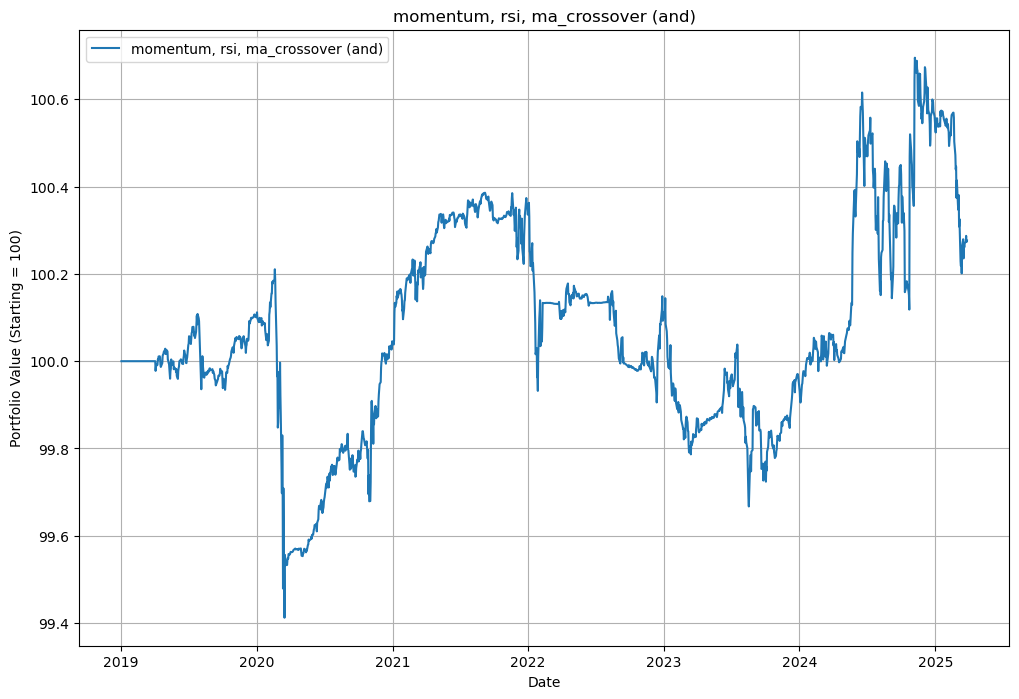

In [20]:
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],  # Use all three strategies
    lookback_period=63,                                  # ~3 months for momentum
    rsi_window=10,                                       # 10-day RSI
    ma_window=20,                                        # 20-day MA
    rebalance_period=30,                                 # 10-day rebalancing
    num_stocks=10,                                        # Select top/bottom 5 stocks
    portfolio_type='long',                               # Long-only portfolio
    combine_method='and'                                 # Require agreement across strategies
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.842483
Annual Return  0.107745
Volatility     0.177051
Sharpe Ratio   0.608552
Max Drawdown  -0.319372


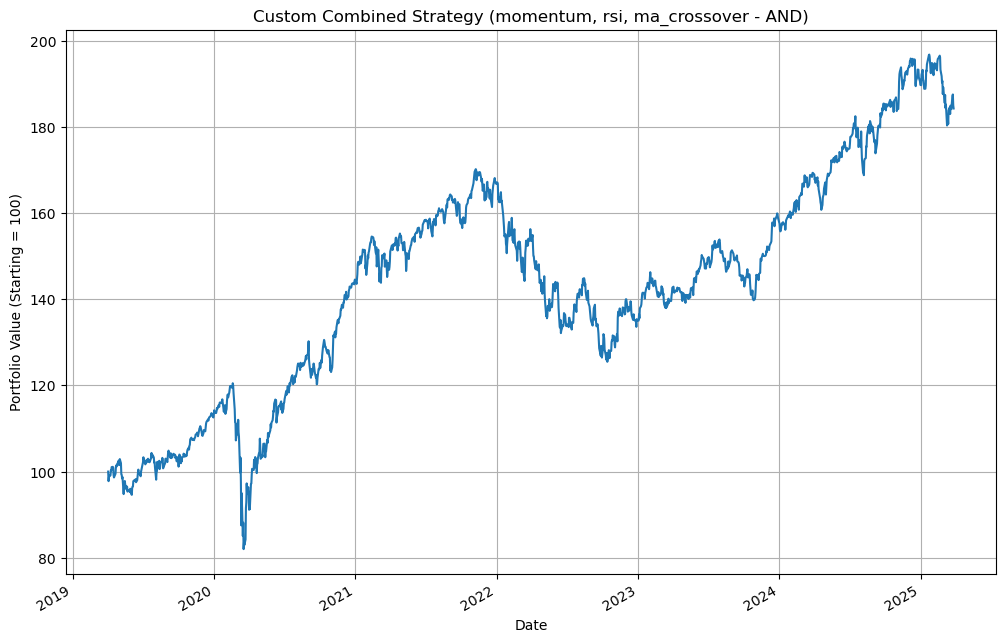

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


etf_data = df

# -------------------- STRATEGY INDICATOR FUNCTIONS --------------------

def calculate_momentum(data, lookback_period):
    """Calculate momentum as percentage price change over the lookback period"""
    return data.pct_change(lookback_period)

def calculate_rsi(data, window=14):
    """Calculate RSI for each ETF using vectorized operations"""
    delta = data.diff()
    # Use vectorized operations instead of where
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Avoid division by zero
    rs = avg_gain / avg_loss.replace(0, np.finfo(float).eps)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_moving_average(data, window=50):
    """Calculate moving average for each ETF"""
    return data.rolling(window=window).mean()


def create_combined_strategy(data, 
                            strategy_types=['momentum'],  
                            lookback_period=252,         
                            rsi_window=14,               
                            ma_window=50,                
                            rebalance_period=21,         
                            num_stocks=10,               
                            portfolio_type='long_short', 
                            combine_method='and'):       
    """
    Create a trading strategy with customizable parameters that can combine multiple strategy types
    """
    # Validate inputs
    valid_strategies = {'momentum', 'rsi', 'ma_crossover'}
    valid_portfolio_types = {'long', 'short', 'long_short'}
    valid_combine_methods = {'and', 'or'}
    
    if not all(strategy in valid_strategies for strategy in strategy_types):
        raise ValueError(f"Invalid strategy type. Must be one of {valid_strategies}")
    
    if portfolio_type not in valid_portfolio_types:
        raise ValueError(f"portfolio_type must be one of {valid_portfolio_types}")
    
    if combine_method not in valid_combine_methods:
        raise ValueError(f"combine_method must be one of {valid_combine_methods}")
    
    # Precompute required indicators only once (optimization)
    indicators = {}
    if 'momentum' in strategy_types:
        indicators['momentum'] = calculate_momentum(data, lookback_period)
    if 'rsi' in strategy_types:
        indicators['rsi'] = calculate_rsi(data, window=rsi_window)
    if 'ma_crossover' in strategy_types:
        ma = calculate_moving_average(data, window=ma_window)
        indicators['ma_crossover'] = data / ma
    
    # Determine the minimum start index based on the strategies used
    min_start_idx = max([
        lookback_period if 'momentum' in strategy_types else 0,
        rsi_window if 'rsi' in strategy_types else 0,
        ma_window if 'ma_crossover' in strategy_types else 0
    ])
    
    # Determine rebalancing dates efficiently
    idx_range = pd.date_range(start=data.index[min_start_idx], end=data.index[-1], freq=f'{rebalance_period}D')
    rebalance_dates = data.index[data.index.searchsorted(idx_range)]
    rebalance_dates = rebalance_dates[rebalance_dates <= data.index[-1]]
    
    # Pre-initialize all dataframes with correct size
    portfolio_top = pd.Series(np.nan, index=data.index)
    portfolio_bottom = pd.Series(np.nan, index=data.index)
    portfolio_combined = pd.Series(np.nan, index=data.index)
    
    # Use boolean arrays for holdings (more memory efficient)
    portfolio_top_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    portfolio_bottom_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    
    # Initial portfolio values
    portfolio_value_top = 100.0
    portfolio_value_bottom = 100.0
    portfolio_value_combined = 100.0
    
    # Calculate daily returns once for the entire period
    daily_returns = data.pct_change().fillna(0)
    
    # Process each rebalance period
    for i, rebalance_date in enumerate(rebalance_dates):
        # Get the index position of the rebalance date
        idx = data.index.get_loc(rebalance_date)
        
        # Precompute all rankings at once for efficiency
        rankings = {}
        for strategy in strategy_types:
            indicator_values = indicators[strategy].iloc[idx]
            
            # Optimize ranking calculations
            if strategy == 'momentum':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
            elif strategy == 'rsi':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=True)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=False)
            elif strategy == 'ma_crossover':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
        
        # Combine rankings efficiently
        if len(strategy_types) > 1:
            if combine_method == 'and':
                # Sum ranks using numpy for speed
                combined_top_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
            else:  # 'or'
                # Use numpy min for speed
                combined_top_rank = pd.Series(
                    np.min([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.min([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
        else:
            # Single strategy case
            combined_top_rank = rankings[f'{strategy_types[0]}_top']
            combined_bottom_rank = rankings[f'{strategy_types[0]}_bottom']
        
        # Select top and bottom performers
        top_assets = combined_top_rank.nsmallest(num_stocks).index
        bottom_assets = combined_bottom_rank.nsmallest(num_stocks).index
        
        # Update holdings efficiently using loc and boolean arrays
        portfolio_top_holdings.loc[rebalance_date, top_assets] = True
        portfolio_bottom_holdings.loc[rebalance_date, bottom_assets] = True
        
        # Find the period dates
        next_rebalance_idx = i + 1
        next_rebalance_date = rebalance_dates[next_rebalance_idx] if next_rebalance_idx < len(rebalance_dates) else data.index[-1]
        period_mask = (data.index >= rebalance_date) & (data.index <= next_rebalance_date)
        period_dates = data.index[period_mask]
        
        # Record initial portfolio values
        portfolio_top.loc[rebalance_date] = portfolio_value_top
        portfolio_bottom.loc[rebalance_date] = portfolio_value_bottom
        portfolio_combined.loc[rebalance_date] = portfolio_value_combined
        
        # Current holdings as boolean masks
        current_top = portfolio_top_holdings.loc[rebalance_date]
        current_bottom = portfolio_bottom_holdings.loc[rebalance_date]
        
        # Process each day efficiently
        for date in period_dates[1:]:  # Skip rebalance date which we've already processed
            # Calculate portfolio returns (vectorized)
            top_returns = daily_returns.loc[date, current_top]
            bottom_returns = daily_returns.loc[date, current_bottom]
            
            port_return_top = top_returns.mean() if current_top.any() else 0
            port_return_bottom = -bottom_returns.mean() if current_bottom.any() else 0
            
            # Update portfolio values
            portfolio_value_top *= (1 + port_return_top)
            portfolio_value_bottom *= (1 + port_return_bottom)
            
            # Calculate combined portfolio value
            if portfolio_type == 'long_short':
                port_return_combined = 0.5 * port_return_top + 0.5 * port_return_bottom
                portfolio_value_combined *= (1 + port_return_combined)
            
            # Record portfolio values
            portfolio_top.loc[date] = portfolio_value_top
            portfolio_bottom.loc[date] = portfolio_value_bottom
            portfolio_combined.loc[date] = portfolio_value_combined
            
            # Copy holdings forward (efficient)
            portfolio_top_holdings.loc[date] = current_top
            portfolio_bottom_holdings.loc[date] = current_bottom
    
    # Create final portfolio based on type - no need to copy data again
    if portfolio_type == 'long':
        final_portfolio = portfolio_top
        final_holdings = portfolio_top_holdings
    elif portfolio_type == 'short':
        final_portfolio = portfolio_bottom
        final_holdings = portfolio_bottom_holdings
    else:  # long_short
        final_portfolio = portfolio_combined
        
        # Create combined holdings efficiently
        final_holdings = pd.DataFrame(0, index=data.index, columns=data.columns)
        long_mask = portfolio_top_holdings
        short_mask = portfolio_bottom_holdings
        
        # Use vectorized operations
        final_holdings[long_mask] = 1
        final_holdings[short_mask] = -1
    
    return {
        'portfolio_values': final_portfolio,
        'holdings': final_holdings,
        'portfolio_top': portfolio_top,
        'portfolio_bottom': portfolio_bottom,
        'portfolio_combined': portfolio_combined,
        'top_holdings': portfolio_top_holdings,
        'bottom_holdings': portfolio_bottom_holdings,
        'strategies_used': strategy_types,
        'combine_method': combine_method
    }


def calculate_performance_metrics(portfolio_values):
    """Calculate performance metrics for a portfolio with vectorized operations"""
    # Drop NaN values once
    clean_values = portfolio_values.dropna()
    
    # Return early if insufficient data
    if len(clean_values) < 2:
        return {
            'Total Return': np.nan,
            'Annual Return': np.nan,
            'Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }
    
    # Calculate metrics in one go
    daily_returns = clean_values.pct_change().iloc[1:]  # Skip first day
    total_return = (clean_values.iloc[-1] / clean_values.iloc[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(clean_values)) - 1
    volatility = daily_returns.std() * np.sqrt(252)
    
    # Avoid division by zero
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    
    # Calculate drawdown vector in one step
    drawdown = clean_values / clean_values.cummax() - 1
    max_drawdown = drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }


def plot_strategy_performance(strategies_dict, title="Strategy Performance"):
    """Plot the performance of multiple strategies with optimized plotting"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Normalize all series at once for efficiency
    normalized_data = pd.DataFrame({
        name: 100 * portfolio / portfolio.iloc[0] 
        for name, portfolio in strategies_dict.items()
    })
    
    # Plot all series in one go
    normalized_data.plot(ax=ax, grid=True)
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value (Starting = 100)')
    
    return plt


# -------------------- CUSTOM COMBINED STRATEGY FUNCTION --------------------

def create_custom_combined_strategy(data, 
                                   strategy_types=['momentum', 'rsi'],
                                   lookback_period=252,
                                   rsi_window=14,
                                   ma_window=50,
                                   rebalance_period=21,
                                   num_stocks=10,
                                   portfolio_type='long_short',
                                   combine_method='and'):
    """
    Create a custom combined strategy with user-specified parameters
    
    Returns the strategy results and performance metrics
    """
    print(f"Creating custom combined strategy with parameters:")
    print(f"  - Strategies used: {strategy_types}")
    print(f"  - Combination method: {combine_method}")
    print(f"  - Lookback period: {lookback_period} days")
    print(f"  - RSI window: {rsi_window} days")
    print(f"  - MA window: {ma_window} days")
    print(f"  - Rebalance period: {rebalance_period} days")
    print(f"  - Number of stocks: {num_stocks}")
    print(f"  - Portfolio type: {portfolio_type}")
    
    # Create the strategy
    result = create_combined_strategy(
        data,
        strategy_types=strategy_types,
        lookback_period=lookback_period,
        rsi_window=rsi_window,
        ma_window=ma_window,
        rebalance_period=rebalance_period,
        num_stocks=num_stocks,
        portfolio_type=portfolio_type,
        combine_method=combine_method
    )
    
    # Calculate performance metrics
    portfolio_values = result['portfolio_values'].dropna()
    metrics = calculate_performance_metrics(portfolio_values)
    
    # Plot the performance (more efficient way)
    fig, ax = plt.subplots(figsize=(12, 8))
    normalized = 100 * portfolio_values / portfolio_values.iloc[0]
    normalized.plot(ax=ax, grid=True)
    ax.set_title(f"Custom Combined Strategy ({', '.join(strategy_types)} - {combine_method.upper()})")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value (Starting = 100)')
    
    return {
        'result': result,
        'metrics': metrics,
        'plot': plt
    }


# Example of using the custom combined strategy function
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],
    lookback_period=63,
    rsi_window=10,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and'
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum']
  - Combination method: and
  - Lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long

Custom Combined Strategy Performance Metrics:
                      0
Total Return   1.668482
Annual Return  0.178622
Volatility     0.226763
Sharpe Ratio   0.787702
Max Drawdown  -0.312727


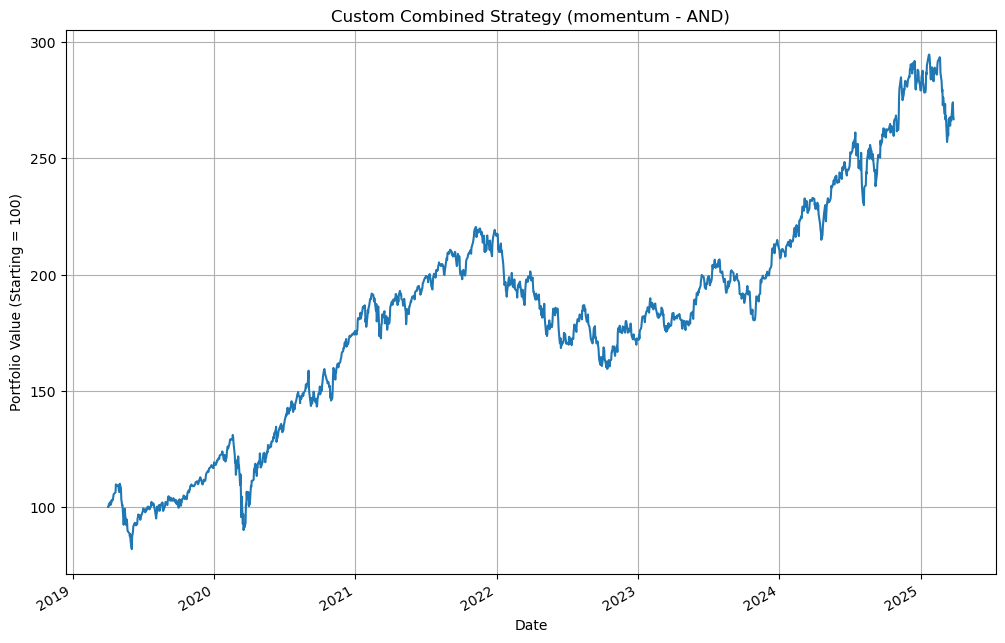

In [6]:
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum'],
    lookback_period=63,
    rsi_window=10,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and'
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: or
  - Lookback period: 63 days
  - RSI window: 21 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.759259
Annual Return  0.099204
Volatility     0.122093
Sharpe Ratio   0.812531
Max Drawdown  -0.197380


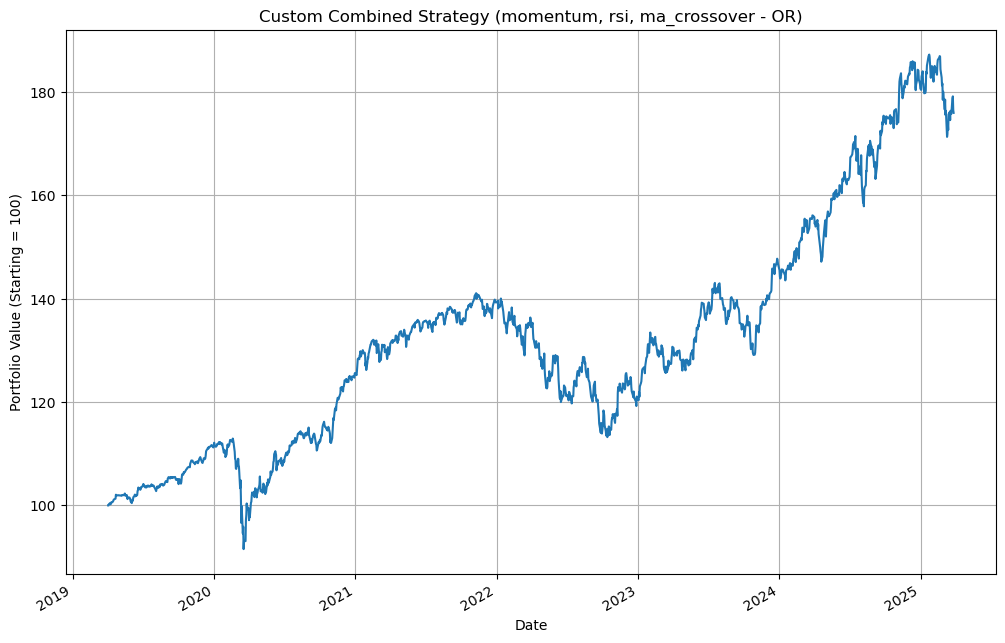

In [17]:
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum','rsi','ma_crossover'],
    lookback_period=63,
    rsi_window=21,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='or'
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
# custom_combined['plot'].savefig('custom_combined_strategy.png')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures
import itertools
import time
from tqdm.notebook import tqdm  # For progress tracking (use tqdm instead if not in notebook)

def optimize_strategy(data, 
                     strategy_types_options=[['momentum'], ['rsi'], ['ma_crossover'], 
                                           ['momentum', 'rsi'], ['momentum', 'ma_crossover'], 
                                           ['rsi', 'ma_crossover'], ['momentum', 'rsi', 'ma_crossover']],
                     lookback_periods=[21, 63, 126, 252],  # ~1 month, 3 months, 6 months, 12 months
                     rsi_windows=[5, 10, 14, 21],
                     ma_windows=[10, 20, 50, 100],
                     rebalance_periods=[5, 10, 21, 42],  # ~1 week, 2 weeks, 1 month, 2 months
                     num_stocks_options=[3, 5, 10],
                     portfolio_types=['long', 'short', 'long_short'],
                     combine_methods=['and', 'or'],
                     max_workers=8,  # Number of parallel threads
                     progress_bar=True):
    """
    Optimize the ETF trading strategy by testing combinations of parameters.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        ETF price data with dates as index and tickers as columns
    
    Returns:
    --------
    pandas.DataFrame
        Results of the optimization with strategy parameters and performance metrics
    """
    start_time = time.time()
    print(f"Starting strategy optimization...")
    
    # Generate all parameter combinations
    all_params = []
    total_combos = 0
    
    for strategy_types in strategy_types_options:
        for portfolio_type in portfolio_types:
            for num_stocks in num_stocks_options:
                for rebalance_period in rebalance_periods:
                    
                    # For single strategy types, no need for combine_method
                    if len(strategy_types) == 1:
                        strategy = strategy_types[0]
                        
                        if strategy == 'momentum':
                            for lookback_period in lookback_periods:
                                all_params.append({
                                    'strategy_types': [strategy],
                                    'lookback_period': lookback_period,
                                    'rsi_window': 14,  # Default
                                    'ma_window': 50,   # Default
                                    'rebalance_period': rebalance_period,
                                    'num_stocks': num_stocks,
                                    'portfolio_type': portfolio_type,
                                    'combine_method': 'and'  # Doesn't matter for single strategy
                                })
                                total_combos += 1
                        
                        elif strategy == 'rsi':
                            for rsi_window in rsi_windows:
                                all_params.append({
                                    'strategy_types': [strategy],
                                    'lookback_period': 252,  # Default
                                    'rsi_window': rsi_window,
                                    'ma_window': 50,   # Default
                                    'rebalance_period': rebalance_period,
                                    'num_stocks': num_stocks,
                                    'portfolio_type': portfolio_type,
                                    'combine_method': 'and'  # Doesn't matter for single strategy
                                })
                                total_combos += 1
                        
                        elif strategy == 'ma_crossover':
                            for ma_window in ma_windows:
                                all_params.append({
                                    'strategy_types': [strategy],
                                    'lookback_period': 252,  # Default
                                    'rsi_window': 14,  # Default
                                    'ma_window': ma_window,
                                    'rebalance_period': rebalance_period,
                                    'num_stocks': num_stocks,
                                    'portfolio_type': portfolio_type,
                                    'combine_method': 'and'  # Doesn't matter for single strategy
                                })
                                total_combos += 1
                    
                    # For combined strategies, we need to test different combine_methods
                    else:
                        for combine_method in combine_methods:
                            # Select appropriate parameter combinations based on strategies
                            uses_momentum = 'momentum' in strategy_types
                            uses_rsi = 'rsi' in strategy_types
                            uses_ma = 'ma_crossover' in strategy_types
                            
                            lookback_options = lookback_periods if uses_momentum else [252]
                            rsi_options = rsi_windows if uses_rsi else [14]
                            ma_options = ma_windows if uses_ma else [50]
                            
                            # If we have multiple strategies, limit the combinations to control the total
                            if len(strategy_types) > 1:
                                # Take a sample of combinations for multiple strategies
                                for lookback_period in lookback_options:
                                    for rsi_window in rsi_options:
                                        for ma_window in ma_options:
                                            all_params.append({
                                                'strategy_types': strategy_types,
                                                'lookback_period': lookback_period,
                                                'rsi_window': rsi_window,
                                                'ma_window': ma_window,
                                                'rebalance_period': rebalance_period,
                                                'num_stocks': num_stocks,
                                                'portfolio_type': portfolio_type,
                                                'combine_method': combine_method
                                            })
                                            total_combos += 1
    
    print(f"Generated {total_combos} parameter combinations to test")
    
    # Function to evaluate a single parameter set
    def evaluate_parameter_set(params):
        try:
            result = create_combined_strategy(
                data,
                strategy_types=params['strategy_types'],
                lookback_period=params['lookback_period'],
                rsi_window=params['rsi_window'],
                ma_window=params['ma_window'],
                rebalance_period=params['rebalance_period'],
                num_stocks=params['num_stocks'],
                portfolio_type=params['portfolio_type'],
                combine_method=params['combine_method']
            )
            
            portfolio_values = result['portfolio_values'].dropna()
            
            # Only calculate metrics if we have valid portfolio values
            if len(portfolio_values) > 0:
                metrics = calculate_performance_metrics(portfolio_values)
                
                # Add strategy parameters to the metrics
                metrics_with_params = params.copy()
                metrics_with_params.update(metrics)
                
                # Add strategy name
                strategy_name = ", ".join(params['strategy_types'])
                if len(params['strategy_types']) > 1:
                    strategy_name += f" ({params['combine_method'].upper()})"
                    
                metrics_with_params['strategy_name'] = strategy_name
                
                return metrics_with_params
            else:
                return None
        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            return None
    
    # Run the evaluations in parallel
    results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        if progress_bar:
            futures = list(tqdm(executor.map(evaluate_parameter_set, all_params), total=len(all_params)))
        else:
            futures = list(executor.map(evaluate_parameter_set, all_params))
        
        # Filter out None results
        results = [result for result in futures if result is not None]
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Optimization completed in {elapsed_time:.2f} seconds, evaluated {len(results_df)} valid parameter combinations")
    
    # Sort by Sharpe ratio (descending)
    if 'Sharpe Ratio' in results_df.columns:
        results_df = results_df.sort_values('Sharpe Ratio', ascending=False)
    
    return results_df

def plot_top_strategies(results_df, data, top_n=5, metric='Sharpe Ratio'):
    """
    Plot the performance of the top N strategies based on the specified metric
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    data : pandas.DataFrame
        Original ETF price data
    top_n : int
        Number of top strategies to plot
    metric : str
        Metric to sort by ('Sharpe Ratio', 'Annual Return', etc.)
    
    Returns:
    --------
    matplotlib.pyplot.figure
        Performance plot for top strategies
    """
    # Sort by specified metric and get top N strategies
    sorted_results = results_df.sort_values(metric, ascending=False).head(top_n)
    
    # Strategies to plot
    strategies_to_plot = {}
    
    for _, row in sorted_results.iterrows():
        # Create a descriptive name for the strategy
        strategy_name = f"{row['strategy_name']} ({row['portfolio_type']})"
        strategy_name += f"\nStocks: {row['num_stocks']}, Rebal: {row['rebalance_period']} days"
        
        if 'momentum' in row['strategy_types']:
            strategy_name += f", Mom: {row['lookback_period']}d"
        if 'rsi' in row['strategy_types']:
            strategy_name += f", RSI: {row['rsi_window']}d"
        if 'ma_crossover' in row['strategy_types']:
            strategy_name += f", MA: {row['ma_window']}d"
        
        strategy_name += f"\n{metric}: {row[metric]:.4f}"
        
        # Run the strategy to get portfolio values
        result = create_combined_strategy(
            data,
            strategy_types=row['strategy_types'],
            lookback_period=row['lookback_period'],
            rsi_window=row['rsi_window'],
            ma_window=row['ma_window'],
            rebalance_period=row['rebalance_period'],
            num_stocks=row['num_stocks'],
            portfolio_type=row['portfolio_type'],
            combine_method=row['combine_method']
        )
        
        strategies_to_plot[strategy_name] = result['portfolio_values'].dropna()
    
    # Plot the strategies
    plt.figure(figsize=(14, 10))
    
    for name, portfolio in strategies_to_plot.items():
        # Normalize to 100
        normalized = 100 * portfolio / portfolio.iloc[0]
        plt.plot(normalized.index, normalized, label=name)
    
    plt.title(f"Top {top_n} Strategies Performance (by {metric})")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.legend(fontsize=10)
    plt.grid(True)
    
    return plt

def generate_summary_stats(results_df):
    """
    Generate summary statistics about performance across different parameter choices
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    
    Returns:
    --------
    dict
        Dictionary containing various summary statistics
    """
    summary = {}
    
    # Performance by strategy type
    strategy_groups = []
    for _, row in results_df.iterrows():
        strategy_group = ", ".join(sorted(row['strategy_types']))
        strategy_groups.append(strategy_group)
    
    results_df['strategy_group'] = strategy_groups
    summary['performance_by_strategy'] = results_df.groupby('strategy_group')['Sharpe Ratio'].describe()
    
    # Performance by portfolio type
    summary['performance_by_portfolio_type'] = results_df.groupby('portfolio_type')['Sharpe Ratio'].describe()
    
    # Performance by number of stocks
    summary['performance_by_num_stocks'] = results_df.groupby('num_stocks')['Sharpe Ratio'].describe()
    
    # Performance by rebalance period
    summary['performance_by_rebalance_period'] = results_df.groupby('rebalance_period')['Sharpe Ratio'].describe()
    
    # For single parameters, analyze their impact
    # Momentum lookback period
    mom_df = results_df[results_df['strategy_types'].apply(lambda x: 'momentum' in x)]
    if len(mom_df) > 0:
        summary['performance_by_lookback_period'] = mom_df.groupby('lookback_period')['Sharpe Ratio'].describe()
    
    # RSI window
    rsi_df = results_df[results_df['strategy_types'].apply(lambda x: 'rsi' in x)]
    if len(rsi_df) > 0:
        summary['performance_by_rsi_window'] = rsi_df.groupby('rsi_window')['Sharpe Ratio'].describe()
    
    # MA window
    ma_df = results_df[results_df['strategy_types'].apply(lambda x: 'ma_crossover' in x)]
    if len(ma_df) > 0:
        summary['performance_by_ma_window'] = ma_df.groupby('ma_window')['Sharpe Ratio'].describe()
    
    # Combine method (for multi-strategy only)
    multi_strategy_df = results_df[results_df['strategy_types'].apply(len) > 1]
    if len(multi_strategy_df) > 0:
        summary['performance_by_combine_method'] = multi_strategy_df.groupby('combine_method')['Sharpe Ratio'].describe()
    
    return summary

def create_heatmaps(results_df):
    """
    Create heatmaps to visualize how combinations of parameters affect performance
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    
    Returns:
    --------
    dict
        Dictionary of matplotlib figures with different heatmaps
    """
    heatmaps = {}
    
    # Only include rows with valid Sharpe ratio
    valid_df = results_df[~results_df['Sharpe Ratio'].isna() & ~np.isinf(results_df['Sharpe Ratio'])]
    
    # Rebalance period vs num_stocks
    pivot = valid_df.pivot_table(
        values='Sharpe Ratio', 
        index='rebalance_period',
        columns='num_stocks',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 8))
    heatmap = plt.imshow(pivot.values, cmap='viridis')
    plt.colorbar(heatmap, label='Average Sharpe Ratio')
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel('Number of Stocks')
    plt.ylabel('Rebalance Period (days)')
    plt.title('Average Sharpe Ratio by Rebalance Period and Number of Stocks')
    heatmaps['rebalance_vs_numstocks'] = plt.gcf()
    
    # For momentum strategies, lookback period vs rebalance period
    mom_df = valid_df[valid_df['strategy_types'].apply(lambda x: 'momentum' in x)]
    if len(mom_df) > 0:
        pivot = mom_df.pivot_table(
            values='Sharpe Ratio', 
            index='lookback_period',
            columns='rebalance_period',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        heatmap = plt.imshow(pivot.values, cmap='viridis')
        plt.colorbar(heatmap, label='Average Sharpe Ratio')
        plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
        plt.yticks(np.arange(len(pivot.index)), pivot.index)
        plt.xlabel('Rebalance Period (days)')
        plt.ylabel('Momentum Lookback Period (days)')
        plt.title('Average Sharpe Ratio for Momentum Strategies')
        heatmaps['momentum_params'] = plt.gcf()
    
    # Strategy type vs portfolio type
    # Create strategy type indicator
    strategy_types = []
    for _, row in valid_df.iterrows():
        strategy_type = ", ".join(sorted(row['strategy_types']))
        if len(row['strategy_types']) > 1:
            strategy_type += f" ({row['combine_method']})"
        strategy_types.append(strategy_type)
    
    valid_df['strategy_indicator'] = strategy_types
    
    pivot = valid_df.pivot_table(
        values='Sharpe Ratio', 
        index='strategy_indicator',
        columns='portfolio_type',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 10))
    heatmap = plt.imshow(pivot.values, cmap='viridis')
    plt.colorbar(heatmap, label='Average Sharpe Ratio')
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns, rotation=45)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel('Portfolio Type')
    plt.ylabel('Strategy Type')
    plt.title('Average Sharpe Ratio by Strategy and Portfolio Type')
    plt.tight_layout()
    heatmaps['strategy_vs_portfolio'] = plt.gcf()
    
    return heatmaps

# Example usage:
if __name__ == "__main__":
    # Run the optimization with defined parameters
    optimization_results = optimize_strategy(
        etf_data,
        strategy_types_options=[
            ['momentum'], ['rsi'], ['ma_crossover'],
            ['momentum', 'rsi'], ['momentum', 'ma_crossover'],
            ['rsi', 'ma_crossover'], ['momentum', 'rsi', 'ma_crossover']
        ],
        lookback_periods=[21, 63, 126, 252],
        rsi_windows=[5, 10, 14, 21],
        ma_windows=[10, 20, 50, 100],
        rebalance_periods=[5, 10, 21, 42],
        num_stocks_options=[3, 5, 10],
        portfolio_types=['long', 'short', 'long_short'],
        combine_methods=['and', 'or'],
        max_workers=8  # Adjust based on your system
    )
    
    # Save full results to CSV
    optimization_results.to_csv('strategy_optimization_results.csv')
    
    # Plot top strategies
    top_strategies_plot = plot_top_strategies(optimization_results, etf_data, top_n=5)
    top_strategies_plot.savefig('top_strategies.png')
    
    # Generate summary statistics
    summary_stats = generate_summary_stats(optimization_results)
    
    # Print summary stats
    print("\nPerformance by Strategy Type:")
    print(summary_stats['performance_by_strategy'])
    
    print("\nPerformance by Portfolio Type:")
    print(summary_stats['performance_by_portfolio_type'])
    
    # Create heatmaps
    heatmaps = create_heatmaps(optimization_results)
    
    # Save heatmaps
    for name, fig in heatmaps.items():
        fig.savefig(f'heatmap_{name}.png')
    
    # Print top 10 strategies
    print("\nTop 10 Strategies by Sharpe Ratio:")
    top_10 = optimization_results.head(10)
    print(top_10[['strategy_name', 'portfolio_type', 'num_stocks', 'rebalance_period', 
                  'Sharpe Ratio', 'Annual Return', 'Volatility', 'Max Drawdown']])
    
    # Run the best strategy for the full period
    best_strategy = optimization_results.iloc[0]
    
    best_result = create_combined_strategy(
        etf_data,
        strategy_types=best_strategy['strategy_types'],
        lookback_period=best_strategy['lookback_period'],
        rsi_window=best_strategy['rsi_window'],
        ma_window=best_strategy['ma_window'],
        rebalance_period=best_strategy['rebalance_period'],
        num_stocks=best_strategy['num_stocks'],
        portfolio_type=best_strategy['portfolio_type'],
        combine_method=best_strategy['combine_method']
    )
    
    # Plot the best strategy
    plt.figure(figsize=(14, 10))
    portfolio_values = best_result['portfolio_values'].dropna()
    plt.plot(portfolio_values.index, portfolio_values / portfolio_values.iloc[0] * 100)
    
    best_strategy_name = f"Best Strategy: {', '.join(best_strategy['strategy_types'])}"
    if len(best_strategy['strategy_types']) > 1:
        best_strategy_name += f" ({best_strategy['combine_method'].upper()})"
    best_strategy_name += f" - {best_strategy['portfolio_type'].capitalize()}"
    
    plt.title(best_strategy_name)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.grid(True)
    plt.savefig('best_strategy.png')
    
    print("\nAnalysis complete! Results saved to CSV and plots saved to PNG files.")

Starting strategy optimization...
Generated 8496 parameter combinations to test


  0%|          | 0/8496 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures
import itertools
import time
from tqdm.notebook import tqdm  # For progress tracking (use tqdm instead if not in notebook)

# Define this function outside to make it picklable
def evaluate_parameter_set(params_and_data):
    """
    Evaluate a single parameter set
    
    Parameters:
    -----------
    params_and_data: tuple
        (params, data) where params is the parameter dictionary and data is the price data
    
    Returns:
    --------
    dict or None
        Results with metrics and parameters, or None if error
    """
    params, data = params_and_data
    
    try:
        result = create_combined_strategy(
            data,
            strategy_types=params['strategy_types'],
            lookback_period=params['lookback_period'],
            rsi_window=params['rsi_window'],
            ma_window=params['ma_window'],
            rebalance_period=params['rebalance_period'],
            num_stocks=params['num_stocks'],
            portfolio_type=params['portfolio_type'],
            combine_method=params['combine_method']
        )
        
        portfolio_values = result['portfolio_values'].dropna()
        
        # Only calculate metrics if we have valid portfolio values
        if len(portfolio_values) > 0:
            metrics = calculate_performance_metrics(portfolio_values)
            
            # Add strategy parameters to the metrics
            metrics_with_params = params.copy()
            metrics_with_params.update(metrics)
            
            # Add strategy name
            strategy_name = ", ".join(params['strategy_types'])
            if len(params['strategy_types']) > 1:
                strategy_name += f" ({params['combine_method'].upper()})"
                
            metrics_with_params['strategy_name'] = strategy_name
            
            return metrics_with_params
        else:
            return None
    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        return None

def optimize_strategy(data, 
                     strategy_types_options=[['momentum'], ['rsi'], ['ma_crossover'], 
                                           ['momentum', 'rsi'], ['momentum', 'ma_crossover'], 
                                           ['rsi', 'ma_crossover'], ['momentum', 'rsi', 'ma_crossover']],
                     lookback_periods=[21, 63, 126, 252],  # ~1 month, 3 months, 6 months, 12 months
                     rsi_windows=[5, 10, 14, 21],
                     ma_windows=[10, 20, 50, 100],
                     rebalance_periods=[5, 10, 21, 42],  # ~1 week, 2 weeks, 1 month, 2 months
                     num_stocks_options=[3, 5, 10],
                     portfolio_types=['long', 'short', 'long_short'],
                     combine_methods=['and', 'or'],
                     max_workers=None,  # Auto-determine number of workers
                     progress_bar=True):
    """
    Optimize the ETF trading strategy by testing combinations of parameters.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        ETF price data with dates as index and tickers as columns
    
    Returns:
    --------
    pandas.DataFrame
        Results of the optimization with strategy parameters and performance metrics
    """
    start_time = time.time()
    print(f"Starting strategy optimization...")
    
    # Pre-generate all parameter combinations more efficiently
    all_params = []
    
    # Use list comprehension for faster parameter generation
    for strategy_types in strategy_types_options:
        for portfolio_type in portfolio_types:
            for num_stocks in num_stocks_options:
                for rebalance_period in rebalance_periods:
                    
                    # For single strategy types, no need for combine_method
                    if len(strategy_types) == 1:
                        strategy = strategy_types[0]
                        
                        if strategy == 'momentum':
                            all_params.extend([{
                                'strategy_types': [strategy],
                                'lookback_period': lookback_period,
                                'rsi_window': 14,  # Default
                                'ma_window': 50,   # Default
                                'rebalance_period': rebalance_period,
                                'num_stocks': num_stocks,
                                'portfolio_type': portfolio_type,
                                'combine_method': 'and'  # Doesn't matter for single strategy
                            } for lookback_period in lookback_periods])
                        
                        elif strategy == 'rsi':
                            all_params.extend([{
                                'strategy_types': [strategy],
                                'lookback_period': 252,  # Default
                                'rsi_window': rsi_window,
                                'ma_window': 50,   # Default
                                'rebalance_period': rebalance_period,
                                'num_stocks': num_stocks,
                                'portfolio_type': portfolio_type,
                                'combine_method': 'and'  # Doesn't matter for single strategy
                            } for rsi_window in rsi_windows])
                        
                        elif strategy == 'ma_crossover':
                            all_params.extend([{
                                'strategy_types': [strategy],
                                'lookback_period': 252,  # Default
                                'rsi_window': 14,  # Default
                                'ma_window': ma_window,
                                'rebalance_period': rebalance_period,
                                'num_stocks': num_stocks,
                                'portfolio_type': portfolio_type,
                                'combine_method': 'and'  # Doesn't matter for single strategy
                            } for ma_window in ma_windows])
                    
                    # For combined strategies, we need to test different combine_methods
                    else:
                        for combine_method in combine_methods:
                            # Select appropriate parameter combinations based on strategies
                            uses_momentum = 'momentum' in strategy_types
                            uses_rsi = 'rsi' in strategy_types
                            uses_ma = 'ma_crossover' in strategy_types
                            
                            lookback_options = lookback_periods if uses_momentum else [252]
                            rsi_options = rsi_windows if uses_rsi else [14]
                            ma_options = ma_windows if uses_ma else [50]
                            
                            # Generate parameter combinations more efficiently
                            all_params.extend([{
                                'strategy_types': strategy_types,
                                'lookback_period': lookback_period,
                                'rsi_window': rsi_window,
                                'ma_window': ma_window,
                                'rebalance_period': rebalance_period,
                                'num_stocks': num_stocks,
                                'portfolio_type': portfolio_type,
                                'combine_method': combine_method
                            } for lookback_period in lookback_options
                              for rsi_window in rsi_options
                              for ma_window in ma_options])
    
    total_combos = len(all_params)
    print(f"Generated {total_combos} parameter combinations to test")
    
    # Choose optimal number of workers if not specified
    if max_workers is None:
        import os
        max_workers = min(32, os.cpu_count() + 4)  # Use CPU count + 4 as recommended for I/O-bound tasks
        print(f"Auto-selected {max_workers} worker threads")
    
    # Create input tuples with data for each parameter set
    params_and_data = [(param, data) for param in all_params]
    
    # Use ThreadPoolExecutor instead of ProcessPoolExecutor due to pickling issues
    executor_class = concurrent.futures.ThreadPoolExecutor
    
    # Run the evaluations in parallel with optimized batch processing
    results = []
    
    # Process in chunks to improve performance
    chunk_size = max(1, min(1000, total_combos // (max_workers * 4)))  # Ensure at least 4 chunks per worker
    
    with executor_class(max_workers=max_workers) as executor:
        # Split into chunks for better progress reporting and memory management
        param_chunks = [params_and_data[i:i + chunk_size] for i in range(0, len(params_and_data), chunk_size)]
        
        if progress_bar:
        #     # Submit all at once but process with progress tracking
        #     futures = list(executor.map(evaluate_parameter_set, params_and_data))
            
        #     # Process results as they come in
        #     for result in tqdm(futures, total=len(params_and_data)):
        #         if result is not None:
        #             results.append(result)
        # else:
        #     # Without progress bar, use simpler approach
        #     for result in executor.map(evaluate_parameter_set, params_and_data):
        #         if result is not None:
        #             results.append(result)
            futures = [executor.submit(evaluate_parameter_set, param_data) for param_data in params_and_data]
            with tqdm(total=len(futures), desc="Optimizing Strategies") as pbar:
                for future in concurrent.futures.as_completed(futures):
                    result = future.result()
                    if result is not None:
                        results.append(result)
                    pbar.update(1)
        else:
            # Without progress bar
            for result in executor.map(evaluate_parameter_set, params_and_data):
                if result is not None:
                    results.append(result)

    
    # Convert results to DataFrame more efficiently
    results_df = pd.DataFrame(results)
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Optimization completed in {elapsed_time:.2f} seconds, evaluated {len(results_df)} valid parameter combinations")
    
    # Sort by Sharpe ratio (descending)
    if 'Sharpe Ratio' in results_df.columns:
        results_df = results_df.sort_values('Sharpe Ratio', ascending=False, ignore_index=True)
    
    return results_df

def plot_top_strategies(results_df, data, top_n=5, metric='Sharpe Ratio'):
    """
    Plot the performance of the top N strategies based on the specified metric
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    data : pandas.DataFrame
        Original ETF price data
    top_n : int
        Number of top strategies to plot
    metric : str
        Metric to sort by ('Sharpe Ratio', 'Annual Return', etc.)
    
    Returns:
    --------
    matplotlib.pyplot.figure
        Performance plot for top strategies
    """
    # Sort by specified metric and get top N strategies
    sorted_results = results_df.sort_values(metric, ascending=False).head(top_n)
    
    # Strategies to plot
    strategies_to_plot = {}
    
    # For plotting, we can pre-cache the results if using the same data
    for _, row in sorted_results.iterrows():
        # Create a descriptive name for the strategy
        strategy_name = f"{row['strategy_name']} ({row['portfolio_type']})"
        strategy_name += f"\nStocks: {row['num_stocks']}, Rebal: {row['rebalance_period']} days"
        
        if 'momentum' in row['strategy_types']:
            strategy_name += f", Mom: {row['lookback_period']}d"
        if 'rsi' in row['strategy_types']:
            strategy_name += f", RSI: {row['rsi_window']}d"
        if 'ma_crossover' in row['strategy_types']:
            strategy_name += f", MA: {row['ma_window']}d"
        
        strategy_name += f"\n{metric}: {row[metric]:.4f}"
        
        # Run the strategy to get portfolio values - using optimized version
        result = create_combined_strategy(
            data,
            strategy_types=row['strategy_types'],
            lookback_period=row['lookback_period'],
            rsi_window=row['rsi_window'],
            ma_window=row['ma_window'],
            rebalance_period=row['rebalance_period'],
            num_stocks=row['num_stocks'],
            portfolio_type=row['portfolio_type'],
            combine_method=row['combine_method']
        )
        
        strategies_to_plot[strategy_name] = result['portfolio_values'].dropna()
    
    # Plot the strategies - using vectorized operations when possible
    plt.figure(figsize=(14, 10))
    
    for name, portfolio in strategies_to_plot.items():
        # Normalize to 100 - vectorized operation
        normalized = 100 * portfolio / portfolio.iloc[0]
        plt.plot(normalized.index, normalized, label=name)
    
    plt.title(f"Top {top_n} Strategies Performance (by {metric})")
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.legend(fontsize=10)
    plt.grid(True)
    
    return plt

def generate_summary_stats(results_df):
    """
    Generate summary statistics about performance across different parameter choices
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    
    Returns:
    --------
    dict
        Dictionary containing various summary statistics
    """
    summary = {}
    
    # More efficient strategy grouping using vectorized operations
    # Create strategy_group in one go instead of looping
    results_df['strategy_group'] = results_df['strategy_types'].apply(lambda x: ", ".join(sorted(x)))
    
    # Compute all summary statistics using optimized groupby operations
    summary['performance_by_strategy'] = results_df.groupby('strategy_group')['Sharpe Ratio'].describe()
    summary['performance_by_portfolio_type'] = results_df.groupby('portfolio_type')['Sharpe Ratio'].describe()
    summary['performance_by_num_stocks'] = results_df.groupby('num_stocks')['Sharpe Ratio'].describe()
    summary['performance_by_rebalance_period'] = results_df.groupby('rebalance_period')['Sharpe Ratio'].describe()
    
    # Create boolean masks for filtering - more efficient than lambda functions
    has_momentum = results_df['strategy_types'].apply(lambda x: 'momentum' in x)
    has_rsi = results_df['strategy_types'].apply(lambda x: 'rsi' in x)
    has_ma = results_df['strategy_types'].apply(lambda x: 'ma_crossover' in x)
    multi_strategy = results_df['strategy_types'].apply(len) > 1
    
    # Apply filters once and reuse
    mom_df = results_df[has_momentum]
    rsi_df = results_df[has_rsi]
    ma_df = results_df[has_ma]
    multi_strategy_df = results_df[multi_strategy]
    
    # Add specific summaries only if we have data
    if len(mom_df) > 0:
        summary['performance_by_lookback_period'] = mom_df.groupby('lookback_period')['Sharpe Ratio'].describe()
    
    if len(rsi_df) > 0:
        summary['performance_by_rsi_window'] = rsi_df.groupby('rsi_window')['Sharpe Ratio'].describe()
    
    if len(ma_df) > 0:
        summary['performance_by_ma_window'] = ma_df.groupby('ma_window')['Sharpe Ratio'].describe()
    
    if len(multi_strategy_df) > 0:
        summary['performance_by_combine_method'] = multi_strategy_df.groupby('combine_method')['Sharpe Ratio'].describe()
    
    return summary

def create_heatmaps(results_df):
    """
    Create heatmaps to visualize how combinations of parameters affect performance
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe from optimize_strategy
    
    Returns:
    --------
    dict
        Dictionary of matplotlib figures with different heatmaps
    """
    heatmaps = {}
    
    # Only include rows with valid Sharpe ratio - vectorized filtering
    valid_mask = ~results_df['Sharpe Ratio'].isna() & ~np.isinf(results_df['Sharpe Ratio'])
    valid_df = results_df[valid_mask]
    
    # Rebalance period vs num_stocks - cached pivot table
    pivot = valid_df.pivot_table(
        values='Sharpe Ratio', 
        index='rebalance_period',
        columns='num_stocks',
        aggfunc='mean'
    )
    
    # Create first heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.imshow(pivot.values, cmap='viridis')
    plt.colorbar(heatmap, label='Average Sharpe Ratio')
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel('Number of Stocks')
    plt.ylabel('Rebalance Period (days)')
    plt.title('Average Sharpe Ratio by Rebalance Period and Number of Stocks')
    heatmaps['rebalance_vs_numstocks'] = plt.gcf()
    
    # Use the already calculated boolean masks for filtering
    has_momentum = valid_df['strategy_types'].apply(lambda x: 'momentum' in x)
    mom_df = valid_df[has_momentum]
    
    # For momentum strategies, lookback period vs rebalance period
    if len(mom_df) > 0:
        pivot = mom_df.pivot_table(
            values='Sharpe Ratio', 
            index='lookback_period',
            columns='rebalance_period',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        heatmap = plt.imshow(pivot.values, cmap='viridis')
        plt.colorbar(heatmap, label='Average Sharpe Ratio')
        plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
        plt.yticks(np.arange(len(pivot.index)), pivot.index)
        plt.xlabel('Rebalance Period (days)')
        plt.ylabel('Momentum Lookback Period (days)')
        plt.title('Average Sharpe Ratio for Momentum Strategies')
        heatmaps['momentum_params'] = plt.gcf()
    
    # Optimize strategy type indicator creation
    valid_df['strategy_indicator'] = valid_df.apply(
        lambda row: ", ".join(sorted(row['strategy_types'])) + 
                    (f" ({row['combine_method']})" if len(row['strategy_types']) > 1 else ""), 
        axis=1
    )
    
    # Create pivot table for strategy vs portfolio heatmap
    pivot = valid_df.pivot_table(
        values='Sharpe Ratio', 
        index='strategy_indicator',
        columns='portfolio_type',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 10))
    heatmap = plt.imshow(pivot.values, cmap='viridis')
    plt.colorbar(heatmap, label='Average Sharpe Ratio')
    plt.xticks(np.arange(len(pivot.columns)), pivot.columns, rotation=45)
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel('Portfolio Type')
    plt.ylabel('Strategy Type')
    plt.title('Average Sharpe Ratio by Strategy and Portfolio Type')
    plt.tight_layout()
    heatmaps['strategy_vs_portfolio'] = plt.gcf()
    
    return heatmaps

# Example usage:
if __name__ == "__main__":
    # Run the optimization with defined parameters
    optimization_results = optimize_strategy(
        etf_data,
        strategy_types_options=[
            ['momentum'], ['rsi'], ['ma_crossover'],
            ['momentum', 'rsi'], ['momentum', 'ma_crossover'],
            ['rsi', 'ma_crossover'], ['momentum', 'rsi', 'ma_crossover']
        ],
        lookback_periods=[21, 63, 126, 252],
        rsi_windows=[5, 10, 14, 21],
        ma_windows=[10, 20, 50, 100],
        rebalance_periods=[5, 10, 21, 42],
        num_stocks_options=[3, 5, 10],
        portfolio_types=['long', 'short', 'long_short'],
        combine_methods=['and', 'or'],
        max_workers=None  # Auto-select optimal number of workers
    )
    
    # Save full results to CSV
    optimization_results.to_csv('strategy_optimization_results.csv', index=False)
    
    # Plot top strategies
    top_strategies_plot = plot_top_strategies(optimization_results, etf_data, top_n=5)
    top_strategies_plot.savefig('top_strategies.png', dpi=300)
    
    # Generate summary statistics
    summary_stats = generate_summary_stats(optimization_results)
    
    # Print summary stats
    print("\nPerformance by Strategy Type:")
    print(summary_stats['performance_by_strategy'])
    
    print("\nPerformance by Portfolio Type:")
    print(summary_stats['performance_by_portfolio_type'])
    
    # Create heatmaps
    heatmaps = create_heatmaps(optimization_results)
    
    # Save heatmaps
    for name, fig in heatmaps.items():
        fig.savefig(f'heatmap_{name}.png', dpi=300)
    
    # Print top 10 strategies
    print("\nTop 10 Strategies by Sharpe Ratio:")
    top_10 = optimization_results.head(10)
    print(top_10[['strategy_name', 'portfolio_type', 'num_stocks', 'rebalance_period', 
                  'Sharpe Ratio', 'Annual Return', 'Volatility', 'Max Drawdown']])
    
    # Run the best strategy for the full period
    best_strategy = optimization_results.iloc[0]
    
    best_result = create_combined_strategy(
        etf_data,
        strategy_types=best_strategy['strategy_types'],
        lookback_period=best_strategy['lookback_period'],
        rsi_window=best_strategy['rsi_window'],
        ma_window=best_strategy['ma_window'],
        rebalance_period=best_strategy['rebalance_period'],
        num_stocks=best_strategy['num_stocks'],
        portfolio_type=best_strategy['portfolio_type'],
        combine_method=best_strategy['combine_method']
    )
    
    # Plot the best strategy
    plt.figure(figsize=(14, 10))
    portfolio_values = best_result['portfolio_values'].dropna()
    plt.plot(portfolio_values.index, portfolio_values / portfolio_values.iloc[0] * 100)
    
    best_strategy_name = f"Best Strategy: {', '.join(best_strategy['strategy_types'])}"
    if len(best_strategy['strategy_types']) > 1:
        best_strategy_name += f" ({best_strategy['combine_method'].upper()})"
    best_strategy_name += f" - {best_strategy['portfolio_type'].capitalize()}"
    
    plt.title(best_strategy_name)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (Starting = 100)')
    plt.grid(True)
    plt.savefig('best_strategy.png', dpi=300)
    
    print("\nAnalysis complete! Results saved to CSV and plots saved to PNG files.")

Starting strategy optimization...
Generated 8496 parameter combinations to test
Auto-selected 24 worker threads


Optimizing Strategies:   0%|          | 0/8496 [00:00<?, ?it/s]